In [1]:
# 加载画图包
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import seaborn as sns

# 设置全局字体
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# setting color palette
# pal = sns.color_palette("Paired")
# sns.set_palette(pal)
# sns.palplot(pal)

In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import pickle
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
import pyranges as pr
import pysam
from collections import Counter, defaultdict

In [3]:
# get last pa sites
# get single polya site gene

last_pa_bed = '/public/home/mowp/workspace/termination/cbRNA_pool/polya_sites/cbRNA.last_polya_cluster_summit.bed'
last_pa = pr.read_bed(last_pa_bed, as_df=True)
last_pa.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ratio']
last_pa.loc[:, 'Chromosome'] = last_pa.loc[:, 'Chromosome'].astype('str')

mask = last_pa.loc[:, 'Name'].str.contains('_1')
single_pa_site_gene = last_pa[mask].loc[:, 'Name'].map(lambda x: x.split('_')[0])

last_pa['Name'] = last_pa['Name'].map(lambda x: x.split('_')[0])
last_pa = last_pa.set_index(['Name'])


# get gene model

gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])

In [4]:
# get protein-coding gene

protein_coding_bed = '/public/home/mowp/db/Arabidopsis_thaliana/bed/Araport11_protein_coding.201606.bed'
protein_coding = pr.read_bed(protein_coding_bed, as_df=True)

protein_coding_gene = set(protein_coding['Name'].map(lambda x: x.split('.')[0]))

In [5]:
all_gene = set(single_pa_site_gene) & protein_coding_gene

In [6]:
def get_target_site(site_type, gene_id):
    if site_type == 'PAS':
        # 获取基因PAS
        return last_pa.at[gene_id, 'End']
    elif site_type == 'TSS':
        # 获取基因TSS
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        values = gene_model.loc[gene_id, :].values
        if values[4] == '+':
            return values[1]
        else:
            return values[2]
    elif site_type == 'TES':
        # 获取基因TES
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        values = gene_model.loc[gene_id, :].values
        if values[4] == '+':
            return values[2]
        else:
            return values[1]
    else:
        raise KeyError



# readthrough length of transcripts with different splicing status

In [7]:
def splice_stats_readthrough_len(infile, gene_id, before=100, after=500, return_median=True):
    '''
    计算基因(加上上下游)区域覆盖度的频数
    '''
    chrom, *_, strand = gene_model.loc[gene_id]
    if chrom in {'Pt', 'Mt'}:
        return None

    target_site = get_target_site('PAS', gene_id)
    
    spliced_rt, unspliced_rt, partially_rt = [], [], []
    
    if strand == '+':
        start = target_site-before
        end = target_site+after
    else:
        start = target_site-after
        end = target_site+before
    
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            intron_count = read.get_tag('sn')  # span_intron_num
            unsplice_count = read.get_tag('rn')  # retention_intron_num
            unsplice_intron = read.get_tag('ri')  # retention_introns
            if intron_count == 0:
                continue
                
            read_gene_id = read.get_tag('gi')
            if read_gene_id not in {gene_id}:
                continue

            if strand == '+':
                read_three_end = read.reference_end
                readthrough_len = read_three_end-target_site
            else:
                read_three_end = read.reference_start
                readthrough_len = target_site-read_three_end
            
            if readthrough_len < 50:
                continue
            

            if unsplice_count == 0:
                spliced_rt.append(readthrough_len)
            elif unsplice_count == intron_count:
                unspliced_rt.append(readthrough_len)
            else:
                partially_rt.append(readthrough_len)
    
    if return_median:
        spliced_n = len(spliced_rt)
        spliced_rt = np.median(spliced_rt) if len(spliced_rt) > 10 else None
        unspliced_n = len(unspliced_rt)
        unspliced_rt = np.median(unspliced_rt) if len(unspliced_rt) > 10 else None
        partially_n = len(partially_rt)
        partially_rt = np.median(partially_rt) if len(partially_rt) > 10 else None
        
        return spliced_rt, spliced_n, unspliced_rt, unspliced_n, partially_rt, partially_n, gene_id
        

    return spliced_rt, unspliced_rt, partially_rt, gene_id


def splice_stats_readthrough_len_turbo(infile, gene_list, threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list)/threads)
        results = e.map(splice_stats_readthrough_len, repeat(infile), gene_list, chunksize=chunksize)
    
    spliced_rt, unspliced_rt, partially_rt = [], [], []
    data = []
    for res in results:
        if res is not None:
            spliced_rt.append(res[0])
            unspliced_rt.append(res[2])
            partially_rt.append(res[4])
            data.append(res)
    return spliced_rt, unspliced_rt, partially_rt, data

In [8]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/cbRNA.elongating.bam'

spliced_rt, unspliced_rt, partially_rt, data = splice_stats_readthrough_len_turbo(infile, all_gene)


In [9]:
data = pd.DataFrame(data, columns=['spliced_rt', 'spliced_n', 'unspliced_rt', 'unspliced_n', 'partially_rt', 'partially_n', 'gene_id'])
data

,spliced_rt,spliced_n,unspliced_rt,unspliced_n,partially_rt,partially_n,gene_id
0,NaN,1,NaN,8,NaN,0,AT4G00490
1,NaN,3,NaN,3,NaN,1,AT5G18550
2,NaN,0,NaN,3,NaN,0,AT1G68600
3,NaN,2,109.0,23,NaN,3,AT2G33770
4,NaN,5,NaN,6,NaN,0,AT5G65450
...,...,...,...,...,...,...,...
13364,NaN,0,NaN,0,NaN,0,AT4G02440
13365,NaN,0,NaN,0,NaN,0,AT4G01070
13366,NaN,3,NaN,0,NaN,1,AT5G10840
13367,NaN,5,150.0,39,197.0,19,AT2G39780


## boxplot

148.25 nt, n=662
180.25 nt, n=662
188.5 nt, n=662


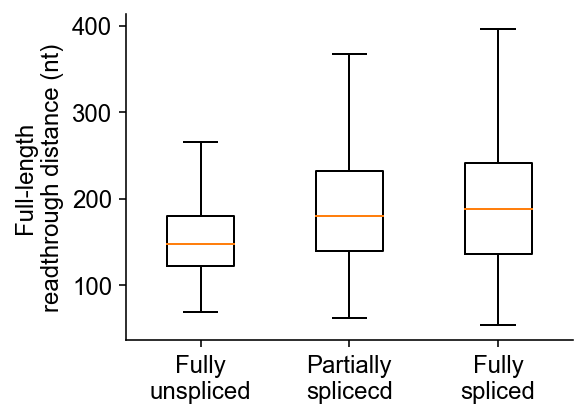

In [10]:
# 基因的不同剪切状态的RT长度

data_ = data.dropna()

plt.figure(figsize=(4, 3))
boxplot_data = [data_['unspliced_rt'], data_['partially_rt'], data_['spliced_rt']]
plt.boxplot(
    boxplot_data,
    showfliers=False,  # 忽略异常值
    labels=['Fully\nunspliced', 'Partially\nsplicecd', 'Fully\nspliced'],
    widths=.45
)
plt.ylabel('Full-length\nreadthrough distance (nt)')
sns.despine(top=True, right=True)
for i in boxplot_data:
    print(f'{np.median(i)} nt, n={len(i)}')

# the splicing status of different kinds of transcripts

In [16]:
def splicing_status_of_transcripts(infile, gene_id, before=100, after=500, return_median=True):
    
    chrom, start, end, _, strand = gene_model.loc[gene_id]
    if chrom in {'Pt', 'Mt'}:
        return None

    target_site = get_target_site('PAS', gene_id)
    
    # splicing status results
    elongating, readthrough, cleaved, polyadenylated = Counter(), Counter(), Counter(), Counter()
    
    if strand == '+':
        start = target_site-before
        end = target_site+after
    else:
        start = target_site-after
        end = target_site+before
    
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            intron_count = read.get_tag('sn')  # span_intron_num
            unsplice_count = read.get_tag('rn')  # retention_intron_num
            unsplice_intron = read.get_tag('ri')  # retention_introns
            if intron_count == 0:
                continue
                
            read_gene_id = read.get_tag('gi')
            polya_len = read.get_tag('pa')
            if read_gene_id not in {gene_id}:
                continue
            
            # get splicing status
            if unsplice_count == 0:
                splicing_status = 'spliced'
            elif unsplice_count == intron_count:
                splicing_status = 'unspliced'
            else:
                splicing_status = 'partially'
                
            # get readthrough length
            if strand == '+':
                read_three_end = read.reference_end
                readthrough_len = read_three_end-target_site
            else:
                read_three_end = read.reference_start
                readthrough_len = target_site-read_three_end
                
            if polya_len > 15:
                polyadenylated[splicing_status] += 1
            elif readthrough_len < -50:
                elongating[splicing_status] += 1
            elif readthrough_len > 50:
                readthrough[splicing_status] += 1
            else:
                cleaved[splicing_status] += 1
        

    return elongating, readthrough, cleaved, polyadenylated, gene_id


def splicing_status_of_transcripts_turbo(infile, gene_list, threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list)/threads)
        results = e.map(splicing_status_of_transcripts, repeat(infile), gene_list, chunksize=chunksize)
    
    elongating, readthrough, cleaved, polyadenylated = Counter(), Counter(), Counter(), Counter()
    for res in results:
        if res is not None:
            elongating += res[0]
            readthrough += res[1]
            cleaved += res[2]
            polyadenylated += res[3]

    return elongating, readthrough, cleaved, polyadenylated

## elongating data

In [47]:
Splice_stats = namedtuple('Splice_stats', 'intron_total_count intron_count unsplice_count unsplice_intron')

splice_stats_pkl = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/elongating_data.bed.splice_stats.tsv'

with open(splice_stats_pkl+'.pkl', 'rb') as f:
    splice_stats_dict = pickle.load(f)

In [18]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/cbRNA.elongating.bam'

elongating, readthrough, cleaved, _ = splicing_status_of_transcripts_turbo(infile, all_gene)


## polyadenylated data

In [217]:
Splice_stats = namedtuple('Splice_stats', 'intron_total_count intron_count unsplice_count unsplice_intron')

splice_stats_pkl = '/public/home/mowp/workspace/termination/cbRNA_pool/polyadenylated_data/polyadenylated_data.bed.splice_stats.tsv'

with open(splice_stats_pkl+'.pkl', 'rb') as f:
    splice_stats_dict = pickle.load(f)

In [19]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/polyadenylated_data/cbRNA.polyadenylated.bam'

*_, polyadenylated = splicing_status_of_transcripts_turbo(infile, all_gene)


In [67]:
splicing_status = pd.DataFrame((readthrough, cleaved, polyadenylated))
splicing_status = splicing_status.div(splicing_status.sum(axis=1), axis=0)
splicing_status = splicing_status[['unspliced', 'partially', 'spliced']]
splicing_status

,unspliced,partially,spliced
0,0.618094,0.178303,0.203603
1,0.415555,0.164213,0.420231
2,0.123722,0.219070,0.657208


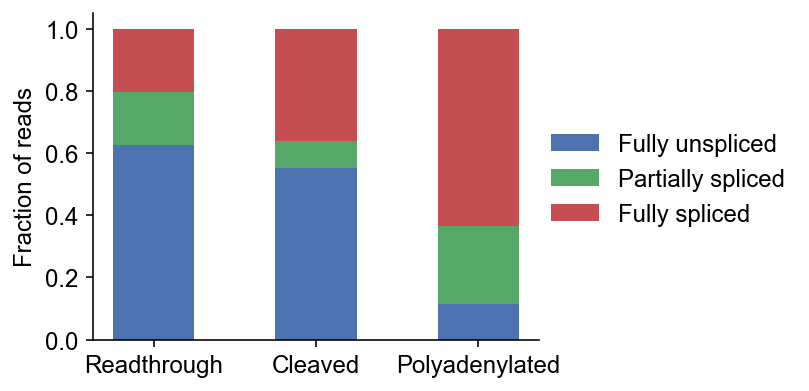

In [31]:
bar_width = 0.5
r = [0, 1, 2]
bottom = np.zeros(len(r))
names = ['Readthrough', 'Cleaved', 'Polyadenylated']
labels = ['Fully unspliced', 'Partially spliced', 'Fully spliced']
colors = ['#4C72B0', '#55A868', '#C44E52']

plt.figure(figsize=(4, 3))
n = 0
for item in splicing_status.T.values:
    plt.bar(r, item, width=bar_width, bottom=bottom, label=labels[n], color=colors[n])
    bottom += item
    n += 1
    
plt.xticks(r, names)
plt.ylabel('Fraction of reads')
#plt.xlim(-.5,1.5)

# plt.style.use('default')
plt.legend(bbox_to_anchor=(.5, .5, 1.1, .2), frameon=False, ncol=1)
sns.despine(top=True, right=True)

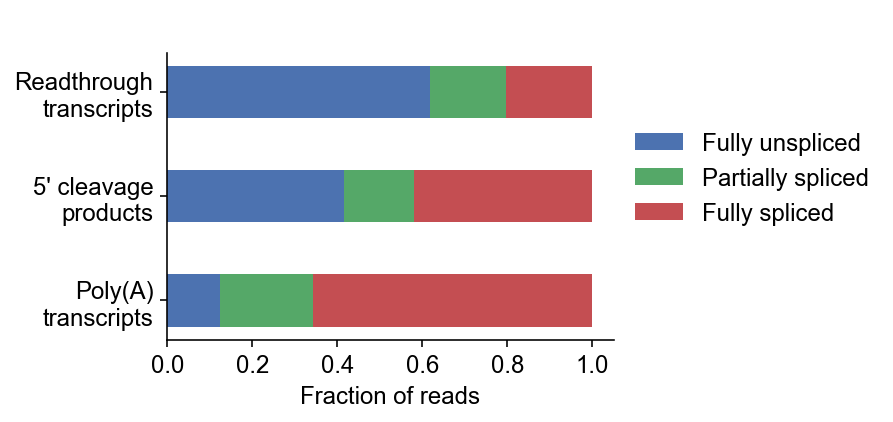

In [82]:
bar_width = 0.5
r = [0, 1, 2]
bottom = np.zeros(len(r))
names = ['Readthrough\ntranscripts', '5\' cleavage\nproducts', 'Poly(A)\ntranscripts']
labels = ['Fully unspliced', 'Partially spliced', 'Fully spliced']
colors = ['#4C72B0', '#55A868', '#C44E52']

fig, ax = plt.subplots(
    2, 1, 
    figsize=(4, 3),
    gridspec_kw={'height_ratios': [.1, 3]},
)
n = 0
bar = []
for item in splicing_status.T.values:
    bar.append(ax[1].barh(r, item, height=bar_width, left=bottom, label=labels[n], color=colors[n]))
    bottom += item
    n += 1
    
plt.yticks(r, names)
plt.xlabel('Fraction of reads')
sns.despine(top=True, right=True)
#plt.xlim(-.5,1.5)
ax[1].invert_yaxis()

# plt.style.use('default')
# ax[0].legend(bar, labels, frameon=False, ncol=2)
ax[1].legend(bar, labels, frameon=False, bbox_to_anchor=(1, .8, 0, 0))
# set legend
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].yaxis.set_major_locator(ticker.NullLocator())
ax[0].xaxis.set_major_locator(ticker.NullLocator())

#sns.despine(top=True, right=True)
plt.savefig('a.svg')

# readthrough distance vs splicing ratio

In [24]:
STRAND_TO_BOOL = {'-': True, '+': False}
def readthrough_splicing_kinetics(infile, gene_id, bw=100):
    '''
    计算readthrough长度与splicing kinetics的关系
    '''
    chrom, start, end, _, gene_strand = gene_model.loc[gene_id]
    
    spliced_ratio = defaultdict(lambda : Counter())
    n = 0
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            intron_count = read.get_tag('sn')  # span_intron_num
            unsplice_count = read.get_tag('rn')  # retention_intron_num
            unsplice_intron = read.get_tag('ri')  # retention_introns
            if intron_count == 0:
                continue
            
            polya_len = read.get_tag('pa')
            gap = read.get_tag('ga')
            read_gene_id = read.get_tag('gi')
            
            if polya_len > 15 or gap >= 5 or read_gene_id != gene_id:
                continue
            
            if gene_strand == '-':
                five_end = read.reference_end*-1
                three_end = read.reference_start*-1
                pa_site = last_pa.at[gene_id, 'End']*-1
            else:
                five_end = read.reference_start
                three_end = read.reference_end
                pa_site = last_pa.at[gene_id, 'End']

            distance = three_end-pa_site
            if distance > 50:
                n += 1
                distance_ = (distance//bw+1)*bw
                spliced_ratio[distance_]['spliced'] += intron_count-unsplice_count
                spliced_ratio[distance_]['total_count'] += intron_count
    if n >= 10:
        return dict(spliced_ratio)

In [ ]:
def readthrough_splicing_kinetics_turbo(infile, gene_list, threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=64) as e:
        results.append(e.submit(readthrough_splicing_kinetics, repeat(infile), gene_list))
    
    x, y = [], []
    for res in results:
        result = res.result()
        if result is not None:
            for distance in result:
                x.append(distance)
                y.append(result[distance]['spliced']/(result[distance]['total_count']))

    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [50]:
def readthrough_splicing_kinetics(infile, gene_id, after=500, bw=100):
    
    chrom, start, end, _, strand = gene_model.loc[gene_id]
    if chrom in {'Pt', 'Mt'}:
        return None

    target_site = get_target_site('PAS', gene_id)
    if strand == '+':
        start = target_site
        end = target_site+after
    else:
        start = target_site-after
        end = target_site
    
    spliced_ratio = defaultdict(lambda : Counter())
    n = 0
    
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            intron_count = read.get_tag('sn')  # span_intron_num
            unsplice_count = read.get_tag('rn')  # retention_intron_num
            unsplice_intron = read.get_tag('ri')  # retention_introns
            if intron_count == 0:
                continue
                
            read_gene_id = read.get_tag('gi')
            polya_len = read.get_tag('pa')
            if read_gene_id not in {gene_id}:
                continue
                
            # get readthrough length
            if strand == '+':
                read_three_end = read.reference_end
                readthrough_len = read_three_end-target_site
            else:
                read_three_end = read.reference_start
                readthrough_len = target_site-read_three_end
            
            if readthrough_len > 50:
                n += 1
                # distance_ = (readthrough_len//bw+1)*bw
                distance_ = round(readthrough_len/bw)*bw
                spliced_ratio[distance_]['spliced'] += intron_count-unsplice_count
                spliced_ratio[distance_]['total_count'] += intron_count
                
    if n >= 15:
        return dict(spliced_ratio)


def readthrough_splicing_kinetics_turbo(infile, gene_list, threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list)/threads)
        results = e.map(readthrough_splicing_kinetics, repeat(infile), gene_list, chunksize=chunksize)
    
    x, y = [], []
    for res in results:
        if res is not None:
            for distance in res:
                x.append(distance)
                y.append(res[distance]['spliced']/(res[distance]['total_count']))
                
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [51]:
infile = '/public/home/mowp/workspace/termination/cbRNA_pool/elongating_data/cbRNA.elongating.bam'
wt_x, wt_y = readthrough_splicing_kinetics_turbo(infile, all_gene)

/public/home/mowp/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


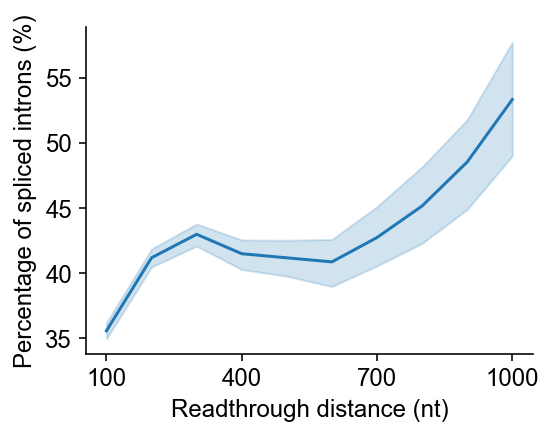

In [52]:
xlim = 1000

plt.figure(figsize=(4, 3))
mask = wt_x <= xlim
sns.lineplot(wt_x[mask], wt_y[mask], markers=True)
# plt.ylim(0, 1)
plt.ylabel('Percentage of spliced introns (%)')
plt.xlabel('Readthrough distance (nt)')


def to_percent(temp, position):
    return '%1.0f'%(100*temp)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.xticks(np.linspace(100, 1000, 4, dtype='int'))
sns.despine(top=True, right=True)